### They inner atoms, and the outer atoms are equally spaced

In [1]:
from tqdm import tqdm
from qutip import *
import numpy as np

from scipy.optimize import minimize

import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial

In [2]:
save_path = r'C:\Users\Leopold\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [11]:
fixed_lam = 1
fixed_gamma = 1

fixed_dist_ext = 0.235  * fixed_lam
fixed_dist_in  =  fixed_dist_ext
fixed_phi  = 0
########################################                 Define constants                   #############################################
N = 3 + 3 * 10

dist_0   = fixed_dist_ext / 2
dist_max = 1.9 * fixed_dist_ext

t_max    = 400

phi_0    = 0
phi_max  = 2 * np.pi / 3

dist_size = 200
t_size    = 200

########################################################################################################################    
dists  = np.linspace(dist_0, dist_max, dist_size)
times  = np.linspace(0, t_max, t_size) * fixed_gamma

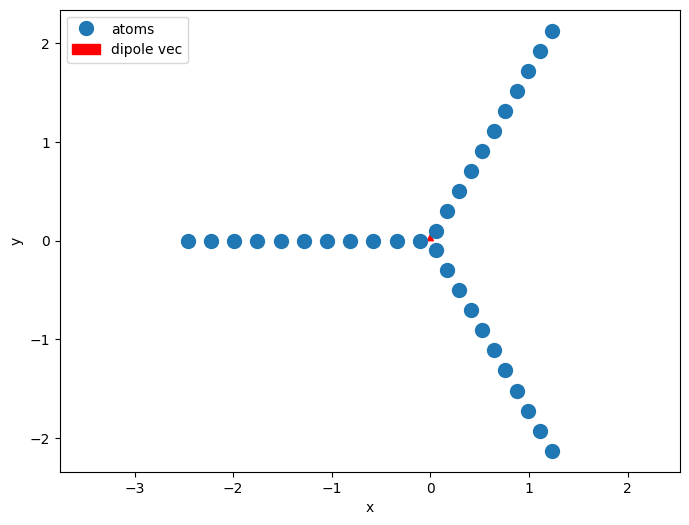

In [12]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi, theta = fixed_gamma):
    """Returns the dipole vector given its orientation by angles phi and theta."""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.array([x, y, z])

d_hats = np.array([np.array([0, 0, 1]) for _ in range(N)])# np.concatenate((d_hats_1, d_hats_rest), axis=0)  #

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
def chain_positions(distance, N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i, 0] = i * distance
    return Pos

# Function to create positions for a topology with three chains meeting at the origin
def topo_positions(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    Pos = np.zeros((N, 3))
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(distance_ext, N // 3) + [r, 0, 0]
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    return Pos
# Function to create positions for a topology with three chains meeting at the origin
def topo_positions_only_1_inner(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    if distance_in >= 2 * distance_ext:
        raise ValueError("The distance distance_in is too large to form a valid triangle with distance_ext.")
    Pos = np.zeros((N, 3))
    Chain = chain_positions(distance_ext, N // 3)
    theta = np.arcsin(distance_in / (2 * distance_ext))
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_ext * np.cos(theta), +distance_ext * np.sin(theta), 0]
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_ext * np.cos(theta), -distance_ext * np.sin(theta), 0]
    return Pos

positions = topo_positions(0.8 * fixed_dist_in, fixed_dist_in)
#print(positions)
d_hat = d_hats[0]
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
plt.figure(figsize=(8, 6))
#plt.plot(positions[N//3 - 1, 0], positions[N//3 - 1, 1], 'x', markersize=20, label='atoms')
#plt.plot(positions[N//3, 0], positions[N//3, 1], 'x', markersize=20, label='atoms')
#plt.plot(positions[N - N//3, 0], positions[N - N//3, 1], 'x', markersize=20, label='atoms')
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
plt.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

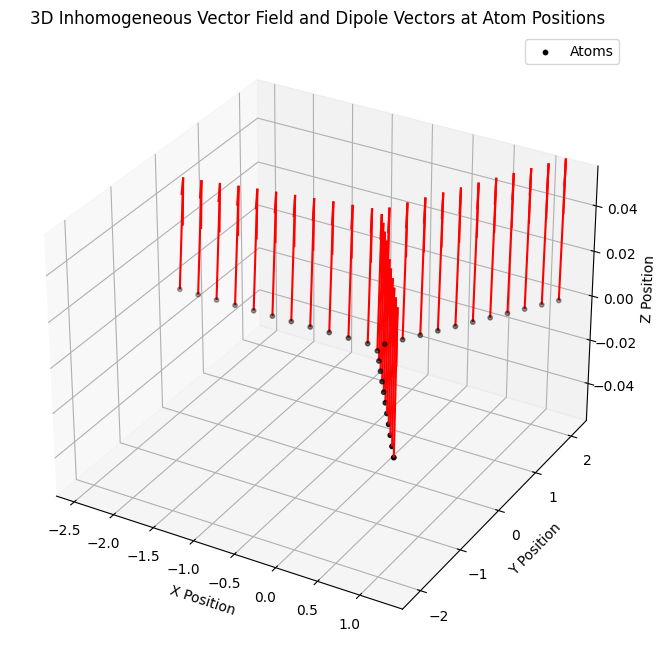

In [17]:
def vector_field(x, y):
    """ Inhomogeneous 3D vector field with smooth transitions. """
    # Calculate phase based on x position
    phase = (x + 10) / 20 * np.pi  # Normalize x to a range of 0 to pi
    
    field_x = np.cos(phase)
    field_y = np.sin(phase)
    field_z = np.sin(phase / 2)  # Introducing some variation in the z-component

    # Normalize the vector
    norm = np.sqrt(field_x**2 + field_y**2 + field_z**2)
    field_x /= norm
    field_y /= norm
    field_z /= norm
    
    return np.array([field_x, field_y, field_z] / np.linalg.norm([field_x, field_y, field_z]))

# Step 3: Extract dipole vectors in 3D space at each atom position
dipole_vectors = np.array([vector_field(x, y) for x, y in zip(positions[:,0], positions[:,1])])
# Plotting the 3D vector field and the dipole vectors
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the atom positions in the x,y plane (z=0)
ax.scatter(positions[:,0], positions[:,1], np.zeros(N), color='black', s=10, label='Atoms')

# Plot the dipole vectors
for i in range(N):
    ax.quiver(positions[:,0][i], positions[:,1][i], 0,
              dipole_vectors[i, 0]* 0.1, dipole_vectors[i, 1]* 0.1, dipole_vectors[i, 2]* 0.1, color='red')

# Setting the labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('3D Inhomogeneous Vector Field and Dipole Vectors at Atom Positions')
ax.legend()

plt.show()

In [ ]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    
    if abs_r_ab < 1e-5:
        return np.zeros((3, 3), dtype=complex)
    
    kappa = k_a * abs_r_ab
    if kappa < 1e-5:
        Greenstensor = np.zeros((3, 3), dtype=complex)
    else:
        Greenstensor = (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                        * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                           + (- kappa ** 2 - 3 * 1j * kappa + 3)
                           * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))
    
    return Greenstensor

def Gamma_coefficients(r_a, r_b,
                       d_a = dipole_vector(), 
                       d_b = dipole_vector(),
                       lam = fixed_lam,
                       gamma = fixed_gamma) -> float:

    if np.linalg.norm(r_b - r_a) < 1e-5:
        return gamma
    k_a = 2 * np.pi / lam
    result = (6 * np.pi * gamma / k_a  # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.imag(result)

def V_coefficients(r_a, r_b,
                   d_a = dipole_vector(), 
                   d_b = dipole_vector(),
                   lam = fixed_lam,
                   gamma = fixed_gamma) -> float:
    
    if np.linalg.norm(r_b - r_a) < 1e-5:
        return 0
    k_a = 2 * np.pi / lam
    result = (-3 * np.pi * gamma / k_a # also / d^2 but it has length 1
              * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T)))
    return np.real(result)

def H_eff(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = topo_positions(distance_in, distance_ext, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

# ###############
# For Optimization and plotting
# ###############

def survival_probabilities(dipoles, times, distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, gamma=fixed_gamma, Psi_0=basis(N, N//6)):
    H = H_eff(distance_in = distance_in, distance_ext = distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    coeffs_sq_mods  = np.zeros((len(times), N))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2

        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()

    return coeffs_sq_mods, P_surs

def compute_total_phase(dist_in, d_hats):
    H = H_eff(distance_in=dist_in, distance_ext=fixed_dist_ext, dipoles=d_hats, lam=fixed_lam, gamma=fixed_gamma, N=N)
    phase = (np.angle(H[N//3 - 1, N//3]) +
             np.angle(H[N//3, N - N//3]) +
             np.angle(H[N - N//3, N//3 - 1])) / (2 * np.pi)
    return phase

def total_phases(distances, dipoles, N=N):
    total_ps = np.zeros((len(distances)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        total_ps[i] = compute_total_phase(distance, dipoles)
    return total_ps

def update(frame, d_hats):
    distance_in = dists[frame]
    phase_value = compute_total_phase(distance_in, d_hats)

    y1, y2 = survival_probabilities(d_hats, times, distance_in=distance_in, Psi_0=psi0)
    
    cax1.set_data(y1.T)
    cax1.set_extent([0, t_max, 0, N-1])
    axs[0, 0].set_title(f'Time evolution of atom state probabilities, distance_in={distance_in:.2f}, ' + r'$P_{tot} = $ ' + f'{phase_value:.2f}')
    
    positions = topo_positions(distance_in=distance_in, distance_ext=fixed_dist_ext, N=N)
    scat.set_offsets(positions[:, :2])
    axs[0, 1].set_title(f'Atom Positions, distance_in={distance_in:.2f}')
    
    # Clear previous arrows
    [arrow.remove() for arrow in axs[0, 1].patches]
    
    # Draw arrows for dipoles
    for i in range(N):
        axs[0, 1].arrow(positions[i, 0], positions[i, 1], d_hats[i][0] * 0.1, d_hats[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
    
    line1.set_data(times, y2)
    line2.set_data(times, np.exp(-times))
    axs[1, 0].relim()
    axs[1, 0].autoscale_view()
    
    line3.set_data(dists, phases)
    marker.set_data(dists[frame], phases[frame])
    axs[1, 1].relim()
    axs[1, 1].autoscale_view()
    
    return cax1, scat, line1, line2, line3, marker


def objective(params, times, distance_ext, gamma, Psi_0, target_indices):
    angles = params[:-1].reshape(3, 2)  # Reshape into pairs of (phi, theta)
    distance_in = params[-1]
    dipoles = np.zeros((N, 3))
    for i in range(3):
        phi, theta = angles[i]
        dipole = dipole_vector(phi, theta)
        if i == 0:
            dipoles[:N//3] = dipole
        elif i == 1:
            dipoles[N//3:2*N//3] = dipole
        else:
            dipoles[2*N//3:] = dipole
    H = H_eff(distance_in=distance_in, distance_ext=distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    U = (-1j * H * times[-1]).expm()
    Psi_t = (U * Psi_0).full().flatten()
    Probs = np.abs(Psi_t)**2
    target_prob = np.sum(Probs[target_indices])
    return -target_prob

# Investigate Photon storage

In [ ]:
################ initiate Wave-packet
k_s = np.pi / fixed_dist_ext
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist_ext)
center_index = N // 6
x_j = (np.arange(N//3) - center_index) * fixed_dist_ext

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()

# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
psi0

In [ ]:
# #################
# Optimize the transition amp into one of the right arms, for the distance and the dipole orientation
# #################

# Define initial parameters (example)
initial_angles = np.zeros(6)  # Three pairs of (phi, theta)
initial_dist_in = fixed_dist_in

# Combine angles and distance_in into a single array for optimization
initial_params = np.hstack((initial_angles, initial_dist_in))

# Define the bounds for the angles (0 to 2*pi for phi and 0 to pi for theta) and for distance_in
angle_bounds = [(0, 2*np.pi) if i % 2 == 0 else (0, np.pi) for i in range(6)]
distance_in_bounds = [(0, None)]  # Adjust this bound according to your physical constraints
bounds = angle_bounds + distance_in_bounds

# Indices of the atoms in the right arms
target_indices = list(range(N//3, 2*N//3))  # Example, assuming the right arms are the latter half

# Optimization with bounds
result = minimize(objective, initial_params, args=(times, fixed_dist_ext, fixed_gamma, psi0, target_indices), method='SLSQP', bounds=bounds)
optimal_params = result.x
optimal_angles = optimal_params[:-1].reshape(3, 2)
optimal_dist_in = optimal_params[-1]

optimal_dipoles = np.zeros((N, 3))
for i in range(3):
    phi, theta = optimal_angles[i]
    dipole = dipole_vector(phi, theta)
    if i == 0:
        optimal_dipoles[:N//3] = dipole
    elif i == 1:
        optimal_dipoles[N//3:2*N//3] = dipole
    else:
        optimal_dipoles[2*N//3:] = dipole

print("Optimal Angles (phi, theta):", optimal_angles)
print("Optimal Dipoles:", optimal_dipoles)
print("Optimal Distance In:", optimal_dist_in)

# Save the optimal parameters
# np.save(save_path + r'\optimal_params.npy', optimal_params)

In [ ]:
# #################
# Plot the optimization for fixed distance and the dipole orientation 
# #################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

# Time evolution plot
times = np.linspace(0, t_max, t_size)
coeffs_sq_mods, P_surs = survival_probabilities(optimal_dipoles, times, distance_in=optimal_dist_in, Psi_0=psi0)

cax1 = ax1.imshow(coeffs_sq_mods.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
fig.colorbar(cax1, ax=ax1, label='Probability')
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')

# Atom positions plot
positions = topo_positions(distance_in=optimal_dist_in, distance_ext=fixed_dist_ext, N=N)
scat = ax2.scatter(positions[:, 0], positions[:, 1], color='blue', s=100)
ax2.set_title('Atom Positions')
ax2.axis('equal')

# Draw arrows for dipoles
for i in range(N):
    ax2.arrow(positions[i, 0], positions[i, 1], optimal_dipoles[i][0] * 0.1, optimal_dipoles[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')

# Survival probability plot
line1, = ax3.plot(times, P_surs, label='Survival Probability')
line2, = ax3.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax3.set_xlabel('Time')
ax3.set_ylabel('Norm (Survival Probability)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
#plt.savefig(save_path + r'\OptimalPlot_upper.png')
plt.show()